In [71]:
import pandas as pd
import numpy as np
import re

import numpy as np
from multiprocessing import cpu_count, Pool
 
cores = cpu_count() # Number of CPU cores on your system
partitions = cores # Define as many partitions as you want
 
def parallelize(data, func):
    data_split = np.array_split(data, partitions)
    pool = Pool(cores)
    data = pool.map(func, data_split)
    pool.close()
    pool.join()
    return data

In [72]:
posts_df = pd.read_json('data/stackoverflow/sample/CombinedDocs.100K.Questions.jsonl.gz', lines=True)
print('Original posts: {:,}'.format(len(posts_df.index)))

Original posts: 273,876


In [73]:
tag_posts = posts_df.dropna(axis=0, subset=['_Tags'])
print('Posts w/ tags: {:,}'.format(len(tag_posts.index)))

Posts w/ tags: 98,278


In [74]:
tag_posts['_Tag_List'] = tag_posts['_Tags'].apply(lambda x: re.findall('\<(.+?)\>', x))

flat_tags = tag_posts.apply(lambda x: pd.Series(x['_Tag_List']),axis=1).stack().reset_index(level=1, drop=True)
flat_tags.index

/home/rjurney/anaconda/envs/deep/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


Int64Index([     4,      6,      6,      6,      6,      8,      8,      8,
                 8,      8,
            ...
            273866, 273867, 273867, 273867, 273867, 273870, 273870, 273872,
            273872, 273875],
           dtype='int64', length=290725)

In [75]:
%matplotlib inline

import matplotlib.pyplot as plt

tag_counts = flat_tags.groupby(flat_tags).count().sort_values(ascending=False)
print(tag_counts[0:10])

javascript    10080
java           8792
c#             7374
php            7303
python         6470
android        6399
jquery         5471
html           4817
c++            3579
css            3397
dtype: int64


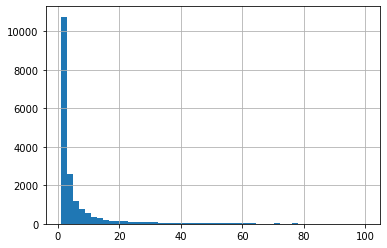

In [76]:
tag_counts[tag_counts <= 100].hist(bins=50)

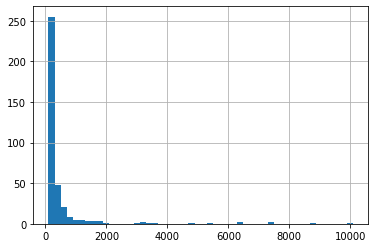

In [77]:
tag_counts[tag_counts > 100].hist(bins=50)

In [78]:
from collections import defaultdict
# import seaborn as sns

tag_counts = defaultdict(int)

for row in tag_posts['_Tag_List']:
    for tag in row:
        tag_counts[tag] += 1

for i in [0, 10, 20, 50, 100, 1000]:
    filtered_tags = list(filter(lambda x: x > i, tag_counts.values()))
    print('There are {:,} tags with more than {:,} count'.format(len(filtered_tags), i))
    # t = pd.Series(filtered_tags, name="Tag Count")
    # ax = sns.distplot(t)

MIN_TAGS = 50

There are 18,549 tags with more than 0 count
There are 2,730 tags with more than 10 count
There are 1,589 tags with more than 20 count
There are 709 tags with more than 50 count
There are 367 tags with more than 100 count
There are 33 tags with more than 1,000 count


In [79]:
all_tags = set()
for row in tag_posts['_Tag_List']:
    for tag in row:
        if tag_counts[tag] > MIN_TAGS:
            all_tags.add(tag)
print('Total unique tags with {:,} occurrences: {:,}'.format(MIN_TAGS, len(all_tags)))
sorted_all_tags = sorted(all_tags)

tag_to_id = {val:i for i, val in enumerate(sorted_all_tags)}
id_to_tag = {i:val for i, val in enumerate(sorted_all_tags)}

Total unique tags with 50 occurrences: 709


In [80]:
labels = []
tag_list = tag_posts['_Tag_List'].tolist()

# Loop through every post...
for i, tag_set in enumerate(tag_posts['_Tag_List'].tolist()):
    # Then build a 709 element wide list for each tag present
    label_row = []
    for tag in sorted_all_tags:
        if tag in tag_list[i]:
            label_row.append(1)
        else:
            label_row.append(0)
    labels.append(label_row)
    
tag_labels = [id_to_tag[key_id] for key_id in sorted(id_to_tag.keys()) if tag_counts[id_to_tag[key_id]] > MIN_TAGS]

len(labels), len(labels[0]), len(tag_labels)

(98278, 709, 709)

In [83]:
from bs4 import BeautifulSoup

# MIN_CODE_LABELS = 20
MIN_TEXT_LABELS = 20


# def extract_code(x):
#     doc = BeautifulSoup(x)
#     return '\n'.join([d.text.lower() for d in doc.find_all('code')])
    
# post_code_text = tag_posts._Body.apply(extract_code)
# post_code_words = [x.split() for x in post_code_text.tolist()]

# # Count the words for testing
# code_word_counts = defaultdict(int)
# all_code_words = set()
# for post in post_code_words:
#     for word in post:
#         code_word_counts[word] += 1
#         all_code_words.add(word)

# sorted_all_code_words = sorted(all_code_words)
# print('All code words: {:,}'.format(len(sorted_all_code_words)))

# code_word_to_id = {word:i for i, word in enumerate(sorted_all_code_words)}
# code_id_to_word = {i:word for i, word in enumerate(sorted_all_code_words)}


def extract_text(x):
    doc = BeautifulSoup(x)
    codes = doc.find_all('code')
    [code.extract() if code else None for code in codes]
    return doc.text

post_text = tag_posts._Body.apply(extract_text)
post_text_words = [x.split() for x in post_text.tolist()]

text_word_counts = defaultdict(int)
all_text_words = set()
for post in post_text_words:
    for word in post:
        text_word_counts[word] += 1
        all_text_words.add(word)

sorted_all_text_words = sorted(all_text_words)
print('All text words: {:,}'.format(len(sorted_all_text_words)))

text_word_to_id = {word:i for i, word in enumerate(sorted_all_text_words)}
text_id_to_word = {i:word for i, word in enumerate(sorted_all_text_words)}


# Take words with > MIN_CODE_LABELS/MIN_TEXT_LABELS (20) instances and build a new set of records and labels/label counts
# encoded_code = []
encoded_text = []
# raw_code_labels = set()
raw_text_labels = set()
# encoded_code_labels = set()
encoded_text_labels = set()
# encoded_code_label_counts = defaultdict(int)
encoded_text_label_counts = defaultdict(int)
# for i, (code, text) in enumerate(zip(post_code_words, post_text_words)):
for i, text in enumerate(post_text_words):
#     encoded_code_row = []
#     for word in code:
#         if code_word_counts[word] > MIN_CODE_LABELS:
#             raw_code_labels.add(word)
#             encoded_code_row.append(code_word_to_id[word])
#             encoded_code_labels.add(code_word_to_id[word])
#             encoded_code_label_counts[word] += 1
    
#     encoded_code.append(encoded_code_row)
    
    encoded_text_row = []
    for word in text:
        if text_word_counts[word] > MIN_TEXT_LABELS:
            raw_text_labels.add(word)
            encoded_text_row.append(text_word_to_id[word])
            encoded_text_labels.add(text_word_to_id[word])
            encoded_text_label_counts[word] += 1
    
    encoded_text.append(encoded_text_row)

# print('Filtered code words: {:,}'.format(len(encoded_code_labels)))
print('Filtered text words: {:,}'.format(len(encoded_text_labels)))

    
# Remove nulls now that we filtered words
post_ids = defaultdict(bool)
# filtered_code_words = []
filtered_text_words = []
for i, text in enumerate(encoded_text):
    if len(text) < 5:
        pass
    else:
        post_ids[i] = True
        # filtered_code_words.append(code)
        filtered_text_words.append(text)

filtered_df = pd.DataFrame({'text': filtered_text_words}) # , 'code': filtered_code_words})
len(filtered_df.index)

All text words: 359,130
Filtered text words: 14,610


98156

In [84]:
filtered_df.head(5)

,text
0,"[158683, 257948, 351353, 250844, 238878, 11459..."
1,"[113673, 335962, 314718, 319722, 173250, 11136..."
2,"[114616, 206655, 178223, 180138, 300013, 33522..."
3,"[114590, 349666, 337859, 194758, 258704, 19937..."
4,"[114590, 238863, 173250, 163351, 91348, 201789..."


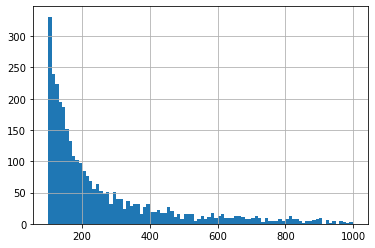

In [85]:
label_counts_df = pd.Series(
    data=[i for i in encoded_code_label_counts.values()],
    index=[i for i in encoded_code_label_counts.keys()]
)
label_counts_df = label_counts_df.sort_values(ascending=False)
label_counts_df[label_counts_df > 100][label_counts_df < 1000].hist(bins=90)

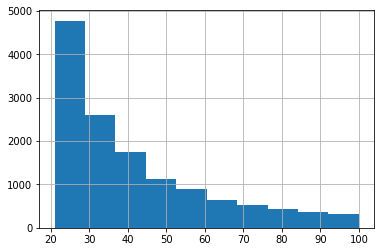

In [86]:
label_counts_df[label_counts_df <= 100].hist(bins=10)

In [87]:
from collections import defaultdict

# Compute a new class label set and label counts that are non-null to match filtered_code_words
new_labels = []
for post_id in post_ids.keys():
    label_set = labels[post_id]
    if post_ids[post_id]:
        new_labels.append(label_set)

del labels
len(new_labels)

98156

In [88]:
# Validate the posts match the labels
assert(len(filtered_df.index) == len(new_labels))
print('We are left with {:,} example posts'.format(len(filtered_df.index)))

We are left with 98,156 example posts


In [89]:
filtered_df['labels'] = new_labels

# filtered_df['code_sums'] = filtered_df['code'].apply(lambda x: sum(x))
filtered_df['text_sums'] = filtered_df['text'].apply(lambda x: sum(x))
# filtered_df = filtered_df[(filtered_df['code_sums'] > 0) & (filtered_df['text_sums'] > 0)]
filtered_df = filtered_df[filtered_df['text_sums'] > 0]

filtered_df['label_max'] = filtered_df['labels'].apply(lambda x: max(x))
filtered_df = filtered_df[filtered_df['label_max'] > 0]

(93169, 709)


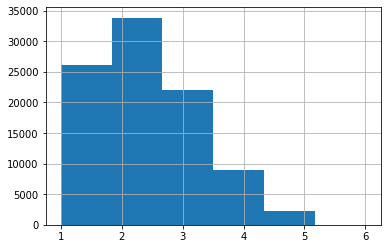

In [90]:
label_ary = np.array(filtered_df['labels'].tolist())
print(label_ary.shape)

label_freq = np.sum(label_ary, axis=1)# / label_ary.shape[1]
pd.Series(label_freq).hist(bins=6)

In [91]:
from sklearn.model_selection import train_test_split

TEST_SPLIT = 0.1

label_mx = np.array(filtered_df['labels'].tolist())
X_train, X_test, y_train, y_test = train_test_split(
    filtered_df,
    label_mx,
    test_size=TEST_SPLIT,
    random_state=33
)

X_train.shape, X_test.shape, y_train.shape, y_test.shape

((83852, 4), (9317, 4), (83852, 709), (9317, 709))

In [92]:
y_train.shape, y_test.shape

((83852, 709), (9317, 709))

In [93]:
from keras.preprocessing.sequence import pad_sequences

# MAX_CODE_LENGTH = 50
MAX_TEXT_LENGTH = 100

# padded_code_train = pad_sequences(X_train['code'], MAX_CODE_LENGTH, padding='post')
# padded_code_test  = pad_sequences(X_test['code'], MAX_CODE_LENGTH, padding='post')

padded_text_train = pad_sequences(X_train['text'], MAX_TEXT_LENGTH, padding='post')
padded_text_test  = pad_sequences(X_test['text'], MAX_TEXT_LENGTH, padding='post')

In [21]:
# from keras.models import Sequential
# from keras.layers import Embedding, SpatialDropout1D, LSTM, Dense

# MAX_NB_WORDS = len(encoded_labels)
# EMBEDDING_DIM = 50

# model = Sequential()
# model.add(Embedding(MAX_NB_WORDS, EMBEDDING_DIM, input_length=X_train.shape[1]))
# model.add(SpatialDropout1D(0.2))
# model.add(LSTM(100, dropout=0.2, recurrent_dropout=0.2))
# model.add(Dense(709, activation='sigmoid'))
# model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

# model.summary()

In [22]:
# padded_code_train.shape[1], 
padded_text_train.shape[1]

(50, 100)

In [94]:
# padded_code_train.shape, padded_text_train.shape, padded_code_train.dtype, padded_text_train.dtype, \
#     y_train.shape, y_test.shape
padded_text_train.shape, padded_text_train.dtype, y_train.shape, y_test.shape

((83852, 100), dtype('int32'), (83852, 709), (9317, 709))

In [95]:
from keras.layers import Input, concatenate, Activation, Dense, LSTM, BatchNormalization, Embedding, Dropout
from keras.metrics import categorical_accuracy, top_k_categorical_accuracy
from keras.models import Model
from keras.optimizers import Adam

# MAX_CODE_NB_WORDS = 5000
MAX_TEXT_NB_WORDS = 5000
# CODE_EMBEDDING_DIM = 64
TEXT_EMBEDDING_DIM = 64

# # Code mdoel
# code_input = Input(shape=(padded_code_train.shape[1],))

# code_embedding = Embedding(
#     MAX_CODE_NB_WORDS, 
#     CODE_EMBEDDING_DIM, 
#     input_length=padded_code_train.shape[1]
# )(code_input)

# code_lstm = LSTM(
#     100,
#     input_shape=(padded_code_train.shape[0], padded_code_train.shape[1] * CODE_EMBEDDING_DIM)
# )(code_embedding)

# code_dropout = Dropout(0.2)(code_lstm)

# code_dense = Dense(709, activation='sigmoid')(code_dropout)

# code_model = Model(inputs=code_input, outputs=code_dense)

# Text model
text_input = Input(shape=(padded_text_train.shape[1],))

text_embedding = Embedding(
    MAX_TEXT_NB_WORDS, 
    TEXT_EMBEDDING_DIM, 
    input_length=padded_text_train.shape[1]
)(text_input)

text_lstm = LSTM(
    100, 
    input_shape=(padded_text_train.shape[0], padded_text_train.shape[1] * TEXT_EMBEDDING_DIM)
)(text_embedding)

text_dropout = Dropout(0.2)(text_lstm)

text_dense = Dense(709, activation='sigmoid')(text_dropout)

text_model = Model(
    inputs=text_input, 
    outputs=text_dense
)

# combined = concatenate(
#     [code_model.output, text_model.output], 
#     axis=1
# )

# combined_dropout = Dropout(0.2)(combined)

# # combined_dense = Dense(
# #     100, 
# #     input_shape=(150,100)
# # )(combined_dropout)

# dense = Dense(709, activation='sigmoid')(combined_dropout)

# # batch = BatchNormalization()(dense)
# # act_output = Activation('sigmoid')(dense)

# model = Model(
#     inputs=[code_model.input, text_model.input], 
#     outputs=dense
# )

from keras import backend as K

def abs_KL_div(y_true, y_pred):
    y_true = K.clip(y_true, K.epsilon(), None)
    y_pred = K.clip(y_pred, K.epsilon(), None)
    return K.sum( K.abs( (y_true- y_pred) * (K.log(y_true / y_pred))), axis=-1)

text_model.compile(loss='binary_crossentropy', optimizer='adam', metrics=[abs_KL_div])

text_model.summary()

# model.compile(
#     loss='binary_crossentropy',
#     optimizer='adam',
#     metrics=[abs_KL_div],
# )

# model.summary()

# for layer in model.layers:
#     print(layer, layer.output_shape)


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_20 (InputLayer)        (None, 100)               0         
_________________________________________________________________
embedding_20 (Embedding)     (None, 100, 64)           320000    
_________________________________________________________________
lstm_20 (LSTM)               (None, 100)               66000     
_________________________________________________________________
dropout_28 (Dropout)         (None, 100)               0         
_________________________________________________________________
dense_18 (Dense)             (None, 709)               71609     
Total params: 457,609
Trainable params: 457,609
Non-trainable params: 0
_________________________________________________________________


In [98]:
from sklearn.utils.class_weight import compute_sample_weight
from keras.callbacks import EarlyStopping

epochs = 4
batch_size = 256

# class_ratios = np.sum(y_train, axis=0) / y_train.shape[0]

# sample_weights = compute_sample_weight('balanced', y_train)

history = text_model.fit(
    padded_text_train,
    y_train,
    epochs=epochs,
    batch_size=batch_size,
    validation_split=0.1,
    callbacks=[
        EarlyStopping(monitor='val_loss', patience=1, min_delta=0.001),
    ],
)

Train on 75466 samples, validate on 8386 samples
Epoch 1/4
75466/75466 [==============================] - 24s 315us/step - loss: 0.0178 - abs_KL_div: 35.7747 - val_loss: 0.0176 - val_abs_KL_div: 34.3409
Epoch 2/4
75466/75466 [==============================] - 24s 315us/step - loss: 0.0178 - abs_KL_div: 35.3732 - val_loss: 0.0176 - val_abs_KL_div: 33.7850


In [99]:
# from sklearn.utils.class_weight import compute_sample_weight
# from keras.callbacks import EarlyStopping

# epochs = 4
# batch_size = 256

# # class_ratios = np.sum(y_train, axis=0) / y_train.shape[0]

# sample_weights = compute_sample_weight('balanced', y_train)

# history = model.fit(
#     [padded_code_train, padded_text_train],
#     y_train,
#     epochs=epochs,
#     batch_size=batch_size,
#     validation_split=0.1,
#     callbacks=[
#         EarlyStopping(monitor='val_loss', patience=1, min_delta=0.001),
#     ],
#     sample_weight=sample_weights
# )

In [100]:
y_train.max(axis=1).min()

1

In [104]:
accr = text_model.evaluate(padded_text_test, y_test)
print('Test set\n  Loss: {:0.3f}\n  Accuracy: {:0.3f}'.format(accr[0],accr[1]))

9317/9317 [==============================] - 7s 774us/step
Test set
  Loss: 0.018
  Accuracy: 33.903


In [106]:
%matplotlib inline

import matplotlib.pyplot as plt

# summarize history for accuracy
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

KeyError: 'acc'

In [ ]:
from sklearn.metrics import hamming_loss, jaccard_score

import keras.backend as K
import tensorflow as tf

y_pred = model.predict([padded_code_test, padded_text_test])

sess = tf.Session()
with sess.as_default():
    for cutoff in [0.0001, 0.001, 0.01, 0.1, 0.2, 0.4, 0.5, 0.6, 0.8]:
        y_pred_bin = K.greater(y_pred, 0.01).eval()
        print('Cutoff: {:,}'.format(cutoff))
        print('Hamming loss: {:,}'.format(
            hamming_loss(y_test, y_pred_bin)
        ))
        for j_type in ['micro', 'macro', 'weighted']:
            print('Jaccard {} score: {:,}'.format(
                j_type,
                jaccard_score(y_test, y_pred_bin, average=j_type)
            ))

In [ ]:
y_pred[1]